In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(".."))

# Comparison with SaTScan

Having discovered further trouble replicating the results of SaTScan, we introduce some more support for reading and writing SaTScan files, and test various corner cases.

The class `AbstractSTScan` works with "generic time" (so just numbers, now interpretted as some time unit _before_ an epoch time).  This allows us to concentrate on the details.  We also introduce a more complicated rule about cases when the boundary of a disc contains more than one point (see below).

The class `STScanNumpy` takes the same data and settings as `AbstractSTScan`, but uses a parallel `numpy` programme style to improve performance.  Like the original implementation, and unlike `AbstractSTScan`, it does nothing special about events which fall on the boundary of disks.

## Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import open_cp.stscan, open_cp.stscan2
import numpy as np

In [3]:
def make_random_data(s=100):
    times = np.floor(np.random.random(size=s) * 200)
    times.sort()
    times = np.flipud(times)
    coords = np.random.random(size=(2,s)) * 100
    return coords, times

def build_ab_scan(coords, times):
    ab_scan = open_cp.stscan2.AbstractSTScan(coords, times)
    ab_scan.geographic_radius_limit = 1000
    ab_scan.geographic_population_limit = 0.5
    ab_scan.time_max_interval = 200
    ab_scan.time_population_limit = 0.5
    return ab_scan

def build_stscan_numpy(coords, times):
    stsn = open_cp.stscan2.STScanNumpy(coords, times)
    stsn.geographic_radius_limit = 1000
    stsn.geographic_population_limit = 0.5
    stsn.time_max_interval = 200
    stsn.time_population_limit = 0.5
    return stsn

def build_trainer(coords, times):
    """Convert to days before 2017-04-01 and use `STSTrainerSlow`."""
    timestamps = (np.timedelta64(1,"D") / np.timedelta64(1,"s")) * times * np.timedelta64(1,"s")
    timestamps = np.datetime64("2017-04-01T00:00") - timestamps
    data = open_cp.data.TimedPoints(timestamps, coords)

    trainer = open_cp.stscan.STSTrainerSlow()
    trainer.data = data
    trainer.time_max_interval = np.timedelta64(200,"D")
    trainer.time_population_limit = 0.5
    trainer.geographic_population_limit = 0.5
    trainer.geographic_radius_limit = 1000
    return trainer

def build_trainer_fast(coords, times):
    """Convert to days before 2017-04-01 and use `STSTrainer`."""
    timestamps = (np.timedelta64(1,"D") / np.timedelta64(1,"s")) * times * np.timedelta64(1,"s")
    timestamps = np.datetime64("2017-04-01T00:00") - timestamps
    data = open_cp.data.TimedPoints(timestamps, coords)

    trainer = open_cp.stscan.STSTrainer()
    trainer.data = data
    trainer.time_max_interval = np.timedelta64(200,"D")
    trainer.time_population_limit = 0.5
    trainer.geographic_population_limit = 0.5
    trainer.geographic_radius_limit = 1000
    return trainer

# Comparison

We find that _most_ of the time, we obtain the same clusters.  But sometimes we don't.  This is down to:

- Non-deterministic ordering.  If we compare things in different orders, we can break ties in different ways.
- As the discs are always centred on events, it is possible for different discs to contain the same events.  As we generate further clusters by finding the next most significant cluster which is _disjoint_ for current clusters, if we again process things in a different order, then we can obtain different disks.

From this point of view, obtaining perfect agreement with SaTScan seems an almost hopeless ideal!

In [4]:
coords, times = make_random_data()
ab_scan = build_ab_scan(coords, times)
all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 83.44944749  78.83457962] 10.4371041119 7.0 5.6761989522
[ 73.84306759  31.95788897] 15.7615978017 9.0 2.91561951977
[ 40.02438171  14.78764756] 2.93866663859 31.0 1.55389696727
[ 67.42867375  93.07261331] 5.40849700151 42.0 1.1694353276
[ 45.62187804  61.93097484] 22.0352926124 24.0 1.10478870264
[  0.21640715  34.16704274] 24.5349564578 85.0 1.0884017762
[  0.87458291  92.12794942] 25.7198471372 84.0 0.759399454025
[ 95.36708922  93.00350443] 3.81892494761 86.0 0.455736816583
[ 17.17880483   0.1537201 ] 9.44004943012 91.0 0.41197139201
[ 90.83989436   0.72739584] 2.44727703358 66.0 0.267989373899
[ 84.29579644  58.5209707 ] 9.1492828288 80.0 0.169569507969
[ 42.19943424   0.84449253] 10.8273261514 65.0 0.0835849165549


In [5]:
stsn = build_stscan_numpy(coords, times)
all_clusters = list(stsn.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 83.44944749  78.83457962] 10.4371041119 7.0 5.6761989522
[ 74.83951416  23.48506725] 13.2925385226 9.0 2.91561951977
[ 40.20234431  11.85437449] 2.93866663859 31.0 1.55389696727
[ 67.42867375  93.07261331] 5.40849700151 42.0 1.1694353276
[ 45.62187804  61.93097484] 22.0352926124 24.0 1.10478870264
[  0.21640715  34.16704274] 24.5349564578 85.0 1.0884017762
[  0.87458291  92.12794942] 25.7198471372 84.0 0.759399454025
[ 80.4735753   50.20832961] 9.1492828288 80.0 0.554519776247
[ 95.36708922  93.00350443] 3.81892494761 86.0 0.455736816583
[ 17.17880483   0.1537201 ] 9.44004943012 91.0 0.41197139201
[ 91.04337871   2.51221386] 2.79745478906 66.0 0.267989373899


In [6]:
trainer = build_trainer(coords, times)
result = trainer.predict(time=np.datetime64("2017-04-01T00:00"))
for c, t, s in zip(result.clusters, result.time_ranges, result.statistics):
    assert np.datetime64("2017-04-01T00:00") == t[1]
    t = (np.datetime64("2017-04-01T00:00") - t[0]) / np.timedelta64(1,"D")
    print(c, t, s)

Cluster(centre=array([ 83.44944749,  78.83457962]), radius=10.437208482949567) 7.0 5.6761989522
Cluster(centre=array([ 73.84306759,  31.95788897]), radius=15.76175541770718) 9.0 2.91561951977
Cluster(centre=array([ 40.20234431,  11.85437449]), radius=2.9386960252543144) 31.0 1.55389696727
Cluster(centre=array([ 67.42867375,  93.07261331]), radius=5.4085510864838655) 42.0 1.1694353276
Cluster(centre=array([ 45.62187804,  61.93097484]), radius=22.035512965311028) 24.0 1.10478870264
Cluster(centre=array([  0.21640715,  34.16704274]), radius=24.535201807315175) 85.0 1.0884017762
Cluster(centre=array([  0.87458291,  92.12794942]), radius=25.720104335628921) 84.0 0.759399454025
Cluster(centre=array([ 91.62502382,  93.76582607]), radius=3.8189631368546819) 86.0 0.455736816583
Cluster(centre=array([ 17.17880483,   0.1537201 ]), radius=9.4401438306144509) 91.0 0.41197139201
Cluster(centre=array([ 90.83989436,   0.72739584]), radius=2.4473015063517352) 66.0 0.267989373899
Cluster(centre=array([ 

In [7]:
trainer_fast = build_trainer_fast(coords, times)
result_fast = trainer_fast.predict(time=np.datetime64("2017-04-01T00:00"))
for c, t, s in zip(result_fast.clusters, result_fast.time_ranges, result_fast.statistics):
    assert np.datetime64("2017-04-01T00:00") == t[1]
    t = (np.datetime64("2017-04-01T00:00") - t[0]) / np.timedelta64(1,"D")
    print(c, t, s)

Cluster(centre=array([ 83.44944749,  78.83457962]), radius=10.437104111908447) 7.0 5.6761989522
Cluster(centre=array([ 74.83951416,  23.48506725]), radius=13.292538522576272) 9.0 2.91561951977
Cluster(centre=array([ 40.20234431,  11.85437449]), radius=2.9386666385879283) 31.0 1.55389696727
Cluster(centre=array([ 67.42867375,  93.07261331]), radius=5.40849700151385) 42.0 1.1694353276
Cluster(centre=array([ 45.62187804,  61.93097484]), radius=22.035292612384904) 24.0 1.10478870264
Cluster(centre=array([  0.21640715,  34.16704274]), radius=24.534956457750596) 85.0 1.0884017762
Cluster(centre=array([  0.87458291,  92.12794942]), radius=25.719847137157547) 84.0 0.759399454025
Cluster(centre=array([ 80.4735753 ,  50.20832961]), radius=9.1492828287981407) 80.0 0.554519776247
Cluster(centre=array([ 95.36708922,  93.00350443]), radius=3.8189249476052054) 86.0 0.455736816583
Cluster(centre=array([ 17.17880483,   0.1537201 ]), radius=9.4400494301201494) 91.0 0.41197139201
Cluster(centre=array([ 9

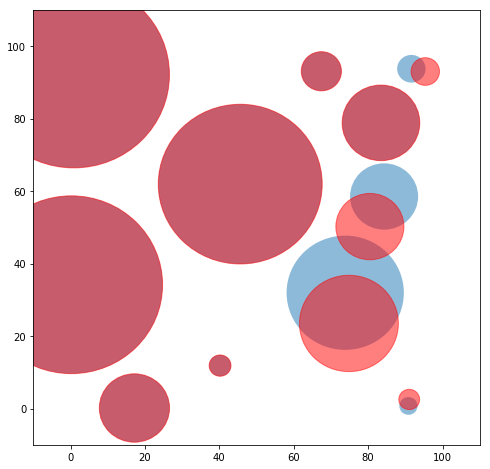

In [8]:
import matplotlib.patches

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlim=[-10,110], ylim=[-10,110])
for c in result.clusters:
    cir = matplotlib.patches.Circle(c.centre, c.radius, alpha=0.5)
    ax.add_patch(cir)
for c in all_clusters:
    cir = matplotlib.patches.Circle(c.centre, c.radius, alpha=0.5, color="red")
    ax.add_patch(cir)

## Timings

The newer code in `AbstractSTScan` is a bit quicker.  The Numpy code is definitely quicker.

In [9]:
%timeit( list(ab_scan.find_all_clusters()) )

1 loop, best of 3: 4.34 s per loop


In [10]:
%timeit( list(stsn.find_all_clusters()) )

10 loops, best of 3: 157 ms per loop


In [11]:
%timeit( trainer.predict() )

1 loop, best of 3: 4.46 s per loop


In [12]:
%timeit( trainer_fast.predict() )

10 loops, best of 3: 157 ms per loop


## Optionally save

We can write the data out in SaTScan format for comparison purposes.  Be sure to adjust Advanced Analysis options in SaTScan to reflect the settings we used above (no limit of size of clusters, but a population limit of 50% for both space and time).~

In [ ]:
#ab_scan.to_satscan("satscan_test2", 1000)

# Grided data

Where we have found quite different behaviour from SaTScan is in "boundary" behaviour.  Consider the case when a disk's boundary (it's circumference) contains more than one event.  The `STSTrainer` class always considers all events inside or on the edge of the disk.  But SaTScan will _sometimes_ consider events inside the disc, and then only _some_ of the events on the boundary.

Notice in particular that we can expect this to happen a lot if the input data is on a regular grid.

We try to replicate this behaviour in `AbstractSTScan` by considering all possibilities of events on the boundary being counted or not.  Unfortunately, we then seem to beat SaTScan at its own game, and consider too many subsets, resulting in finding clusters which SaTScan does not.

The first example below shows where `AbstractSTScan` is more aggresive than SaTScan.  The 2nd example shows where SaTScan does indeed fail to consider all events in a disc, and gets the same result as `AbstractSTScan`.

## Generate example random data

We use the grid abilities of `STSTrainer`.

In [ ]:
def trainer_to_data(trainer):
    coords = trainer.data.coords
    times = (np.datetime64("2017-04-01T00:00") - trainer.data.timestamps) / np.timedelta64(1,"s")
    times /= (np.timedelta64(1,"D") / np.timedelta64(1,"s"))
    times = np.floor(times)
    
    return coords, times

np.testing.assert_array_almost_equal(trainer_to_data(trainer)[0], coords)
np.testing.assert_array_almost_equal(trainer_to_data(trainer)[1], times)

In [ ]:
trainer = build_trainer(*make_random_data())
region = open_cp.RectangularRegion(xmin=0, ymin=0, xmax=100, ymax=100)
ab_scan = build_ab_scan( *trainer_to_data( trainer.grid_coords(region, grid_size=20) ) )

In [ ]:
all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

In [ ]:
#ab_scan.to_satscan("satscan_test1", 1000)

## Reload some data

Here's one we prepared earlier.  It shows a case where our aggressive algorithm finds a cluster which SaTScan does not.

In [ ]:
def find_satscan_ids_for_mask(in_disc, time):
    in_disc &= ab_scan.timestamps <= time
    in_disc = set( (x,y) for x,y in ab_scan.coords[:,in_disc].T )
    return [i for i in satscan_data.geo if satscan_data.geo[i] in in_disc]

def find_mask(centre, radius):
    return np.sum((ab_scan.coords - np.array(centre)[:,None])**2, axis=0) <= radius**2

def to_our_indexes(sat_scan_indexes):
    out = set()
    for i in sat_scan_indexes:
        x, y = satscan_data.geo[i]
        m = (ab_scan.coords[0] == x) & (ab_scan.coords[1] == y)
        for j in np.arange(ab_scan.coords.shape[1])[m]:
            out.add(j)
    return out

In [ ]:
satscan_data = open_cp.stscan2.SaTScanData("satscan_test3", 1000)
ab_scan = build_ab_scan( *satscan_data.to_coords_time() )

all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

In [ ]:
# Cluster which SaTScan finds -- In this case, seemingly SaTScan includes all events
in_disc = find_mask([30,30], 20)
find_satscan_ids_for_mask(in_disc, 70)

In [ ]:
# Our cluster-- all events in or on the disc
in_disc = find_mask([50,30], 20)
find_satscan_ids_for_mask(in_disc, 45)

In [ ]:
# The subset of events our algorithm chooses to use
in_disc = all_clusters[0].mask
find_satscan_ids_for_mask(in_disc, 45)

In [ ]:
# The numpy code should, mostly, replicate what SaTScan does
stsn = build_stscan_numpy( *satscan_data.to_coords_time() )

all_clusters = list(stsn.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

## 2nd Example

This example actually seems to show SaTScan not including all points in a disc.  SaTScan reports:

    1.Location IDs included.: 23, 6, 16
      Coordinates / radius..: (30,30) / 20.00
      Time frame............: 993 to 1000
      Number of cases.......: 3
      Expected cases........: 0.42
      Observed / expected...: 7.14
      Test statistic........: 3.352053
      P-value...............: 0.202
      Recurrence interval...: 5.0 units

Now, we note that:
- Event 23 occurs at times 967 and 924, which are both _outside_ the time window.
- The disc centred at (30,30) of radius 20 contains events 6, 11, 16, 23 and 24.
- If we manually compute the statistic for this disk and time, we get the same value as SaTScan (to be precise, if we change the space window to only include events 6, 16 and 23, we obtain the sample "expected" count).
- The Numpy accelerated code fails to find this cluster, as it includes all events in the disk.

In [ ]:
satscan_data = open_cp.stscan2.SaTScanData("satscan_test1", 1000)
coords, times = satscan_data.to_coords_time()
ab_scan = build_ab_scan(coords, times)

all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

In [ ]:
in_disc = find_mask([30,30], 20)
find_satscan_ids_for_mask(in_disc,7)

In [ ]:
in_disc = find_mask([30,30], 20)
find_satscan_ids_for_mask(in_disc,10000)

In [ ]:
satscan_data.geo[6], satscan_data.geo[16], satscan_data.geo[11], satscan_data.geo[23], satscan_data.geo[24]

In [ ]:
time_mask = times <= 7
space_mask = np.sum( (coords - np.array([30,30])[:,None])**2, axis=0) <= 20**2

expected = np.sum(space_mask) * np.sum(time_mask) / 100
actual = np.sum(space_mask & time_mask)
actual, expected, ab_scan._statistic(actual, expected, 100)

In [ ]:
# The above Statistic is smaller than the one SaTScan finds, because the expected count is too large
# But if we limit the spacial region to the ids SaTScan claims, we obtain a perfect match
expected = len(to_our_indexes([23, 6, 16])) * np.sum(time_mask) / 100
expected

In [ ]:
# The numpy accelerated code doesn't find the same clusters
stsn = build_stscan_numpy(coords, times)

all_clusters = list(stsn.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)